In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import dsplot as dp
import seaborn as sns
from pprint import pprint
import json
from tqdm import tqdm
from IPython.display import clear_output
from datetime import datetime
# import datetime

%matplotlib inline

> `dsplot` is my custom signal processing plotting library, which is a wrapper for `matplotlib` and `plotly`  
More details here: [https://gitlab.com/spbroma/dsplot/](https://gitlab.com/spbroma/dsplot/)

# Data loading

In [2]:
X_train = np.load('X_train.npy')
y_train = np.load('y_train.npy')
X_test  = np.load('X_test.npy')
y_test  = np.load('y_test.npy')


print('X_train: ', X_train.shape)
print('y_train: ', y_train.shape)
print('X_test:  ', X_test.shape)
print('y_test:  ', y_test.shape)

X_train:  (7352, 128, 9)
y_train:  (7352, 6)
X_test:   (2947, 128, 9)
y_test:   (2947, 6)


> Here we see, that second dimension of X is time and we can reshape it to matrix $[N_{channels} \times t \cdot N_{samples}]$  

# Data reshape

In [3]:
X_train = X_train.reshape([-1, 9], order='F')
X_test  = X_test.reshape([-1, 9], order='F')

# # Normalize
# X_train = X_train - np.min(X_train)
# X_test = X_test - np.min(X_test)

# X_train = X_train / np.max(X_train)
# X_test = X_test / np.max(X_test)


y_train = np.tile(y_train, [128, 1])
y_test = np.tile(y_test, [128, 1])

print('X_train: ', X_train.shape)
print('y_train: ', y_train.shape)
print('X_test:  ', X_test.shape)
print('y_test:  ', y_test.shape)

X_train:  (941056, 9)
y_train:  (941056, 6)
X_test:   (377216, 9)
y_test:   (377216, 6)


> It could be good to normalize data and align it ro range $[0, 1]$, but we can't do it by min and max value, because it will lead to bias, which may be different between real measurements in real-time.  
We can normalize it to fixed range, perhaps data is from 5V ADC and it will be in range [-5, 5]. But in my further experiments I work with raw data.

# Visual estimation

(0.0, 500.0)

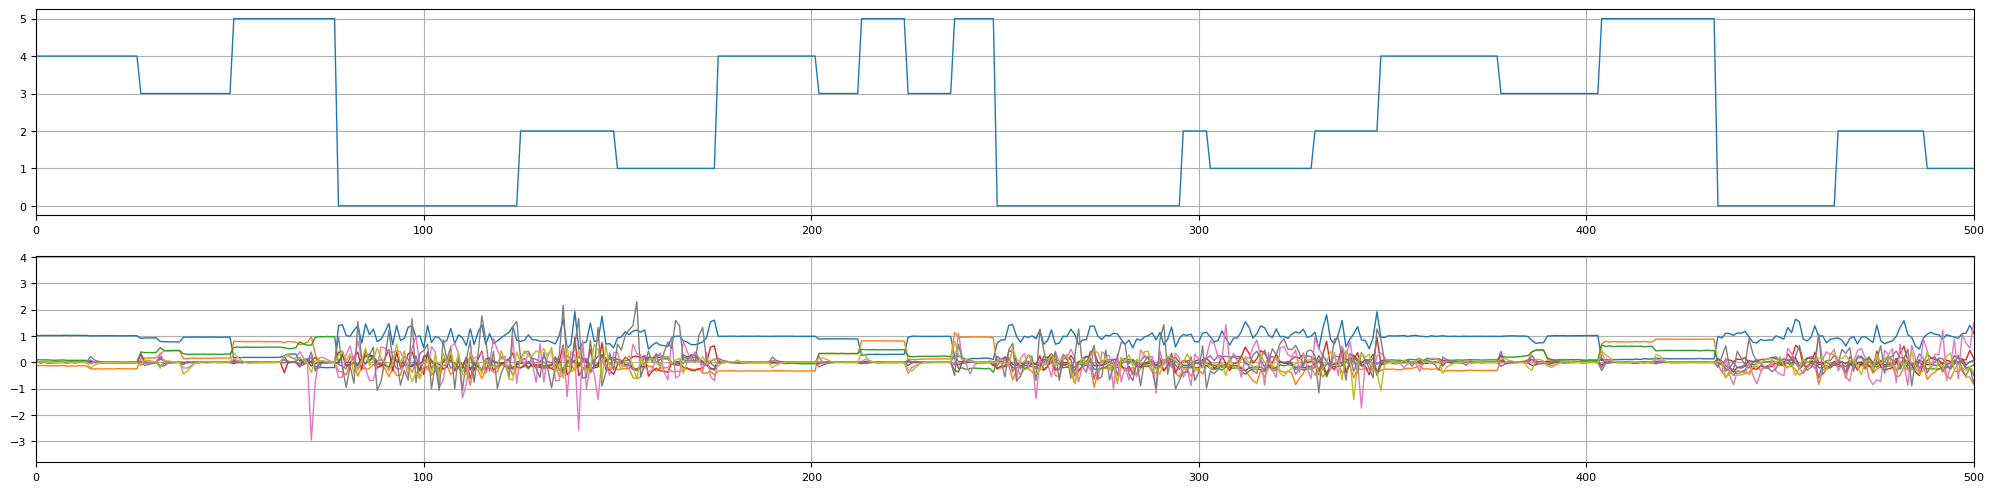

In [6]:
N = 10000
backend = 'matplotlib'

xlim = [0, 500]

y_data = y_train.copy()
X_data = X_train.copy()

plot_data = np.argmax(y_data[:N,:], 1)

plt.figure(figsize=(25,6), dpi=100)
plt.subplot(2,1,1)
dp.plot([plot_data], backend=backend, new=False, show=False)
plt.xlim(xlim)

plot_data = []
for i in range(X_data.shape[1]):
    plot_data.append(X_data[:N,i])

plt.subplot(2,1,2)
dp.plot(plot_data, backend=backend, new=False, show=False)
plt.xlim(xlim)

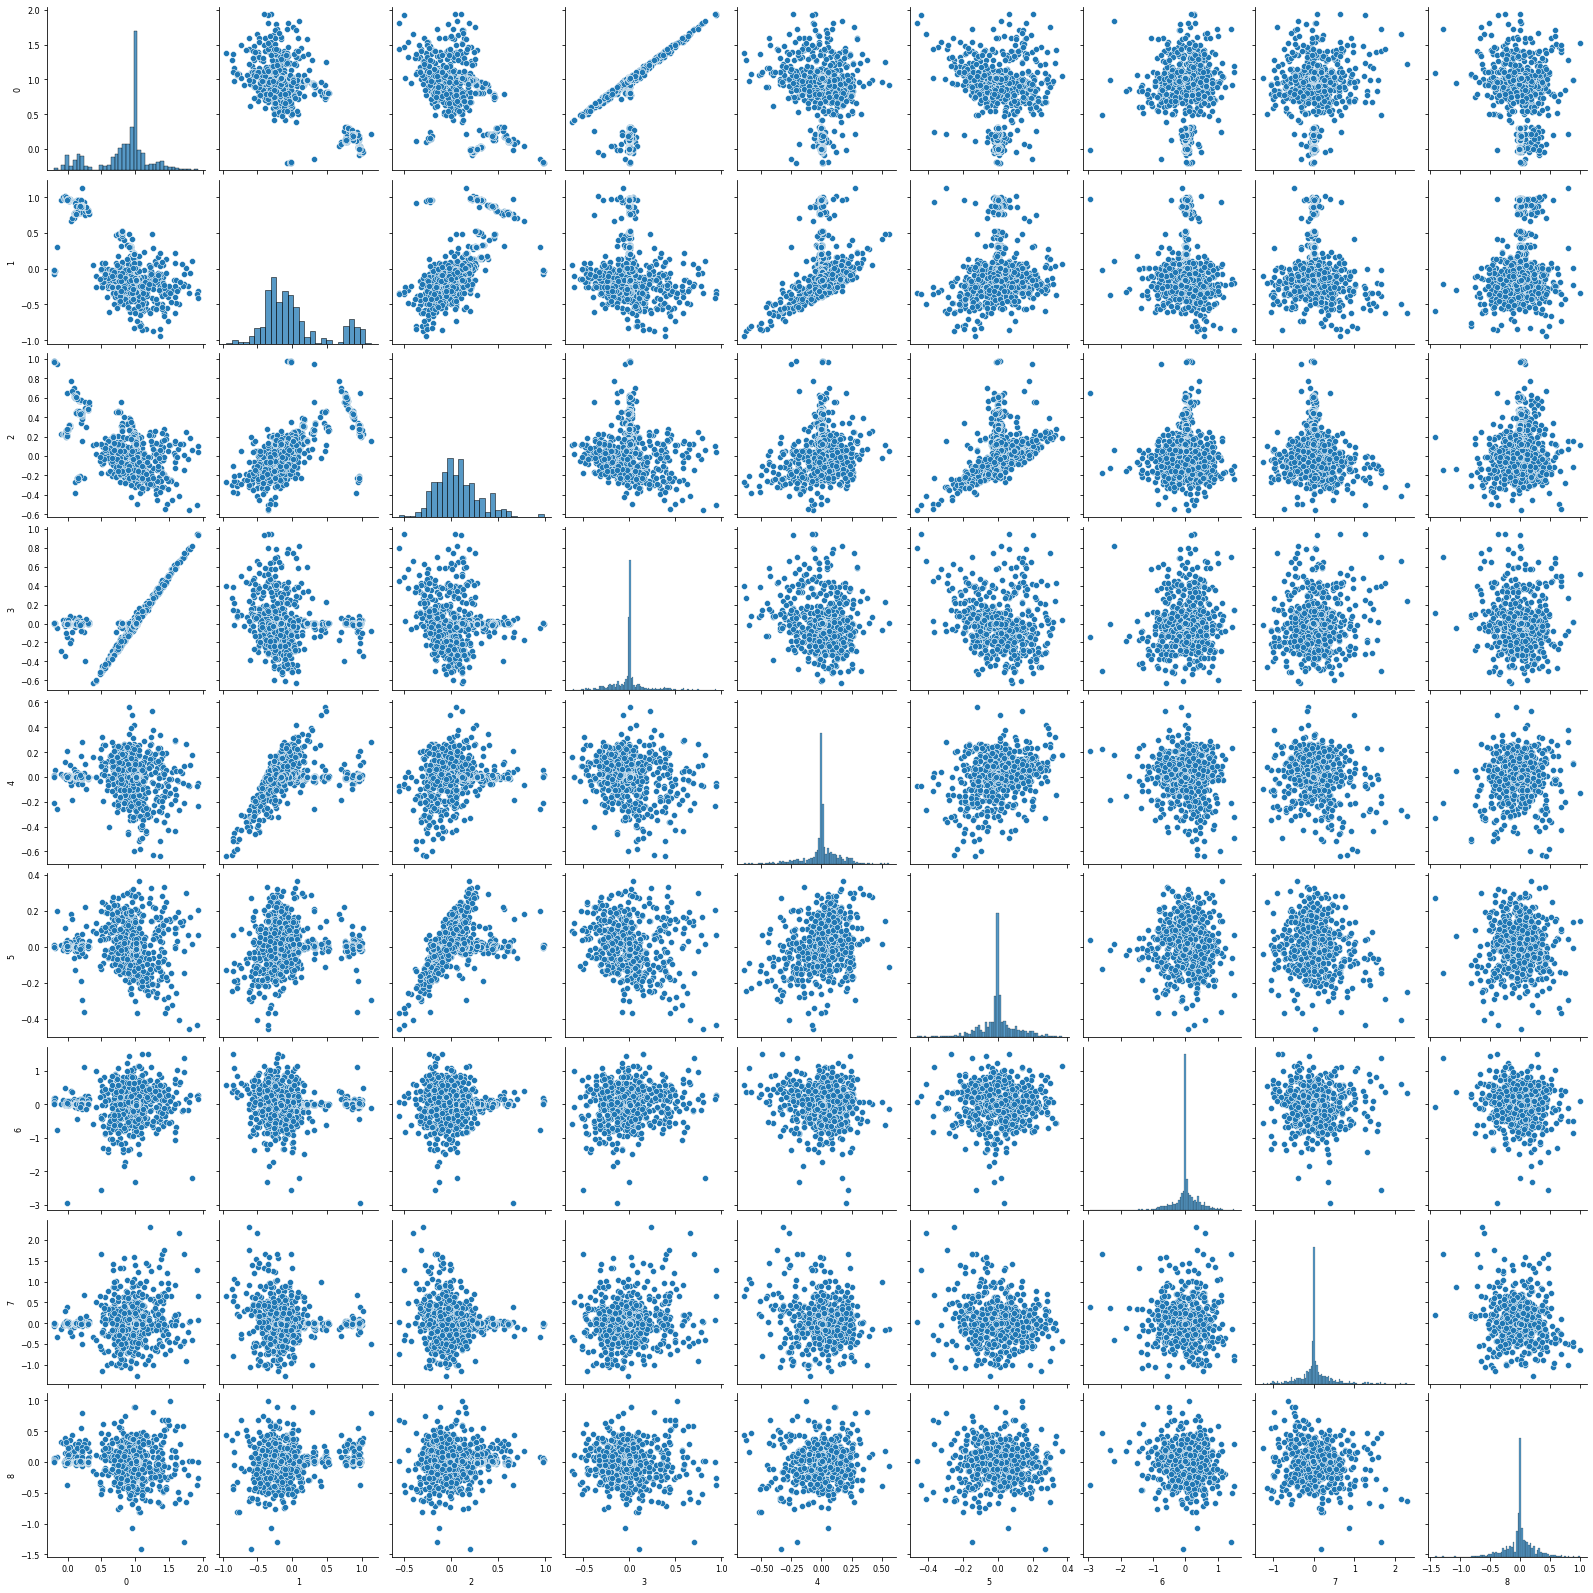

In [5]:
N = 1000
df = pd.DataFrame(X_train)
sns.pairplot(data=df.iloc[:N])
plt.show()


In [6]:
df.describe()

0              1              2              3  \
count  941056.000000  941056.000000  941056.000000  941056.000000   
mean        0.804749       0.028755       0.086498      -0.000636   
std         0.414112       0.390996       0.357769       0.194846   
min        -0.466556      -1.582079      -1.639609      -1.232238   
25%         0.664948      -0.220610      -0.131162      -0.027734   
50%         0.955993      -0.081328       0.039140      -0.000663   
75%         1.019197       0.191284       0.238996       0.007410   
max         2.197618       1.217350       1.281363       1.299912   

                   4              5              6              7  \
count  941056.000000  941056.000000  941056.000000  941056.000000   
mean       -0.000292      -0.000275       0.000506      -0.000824   
std         0.122428       0.106879       0.406815       0.381855   
min        -1.345267      -1.364707      -4.733656      -5.974330   
25%        -0.010666      -0.015600      -0.044328      -0.055065   
50%         0.000667       0.000096       0.000138      -0.000578   
75%         0.021986       0.015543       0.054847       0.036958   
max         0.975976       1.066916       4.155473       5.746062   

                   8  
count  941056.000000  
mean        0.000113  
std         0.255743  
min        -2.763014  
25%        -0.025253  
50%         0.000490  
75%         0.049530  
max         2.365982

> We can see, that some channels are correlated between each other: [1,4], [2,5], [3,6]  
Let's check this

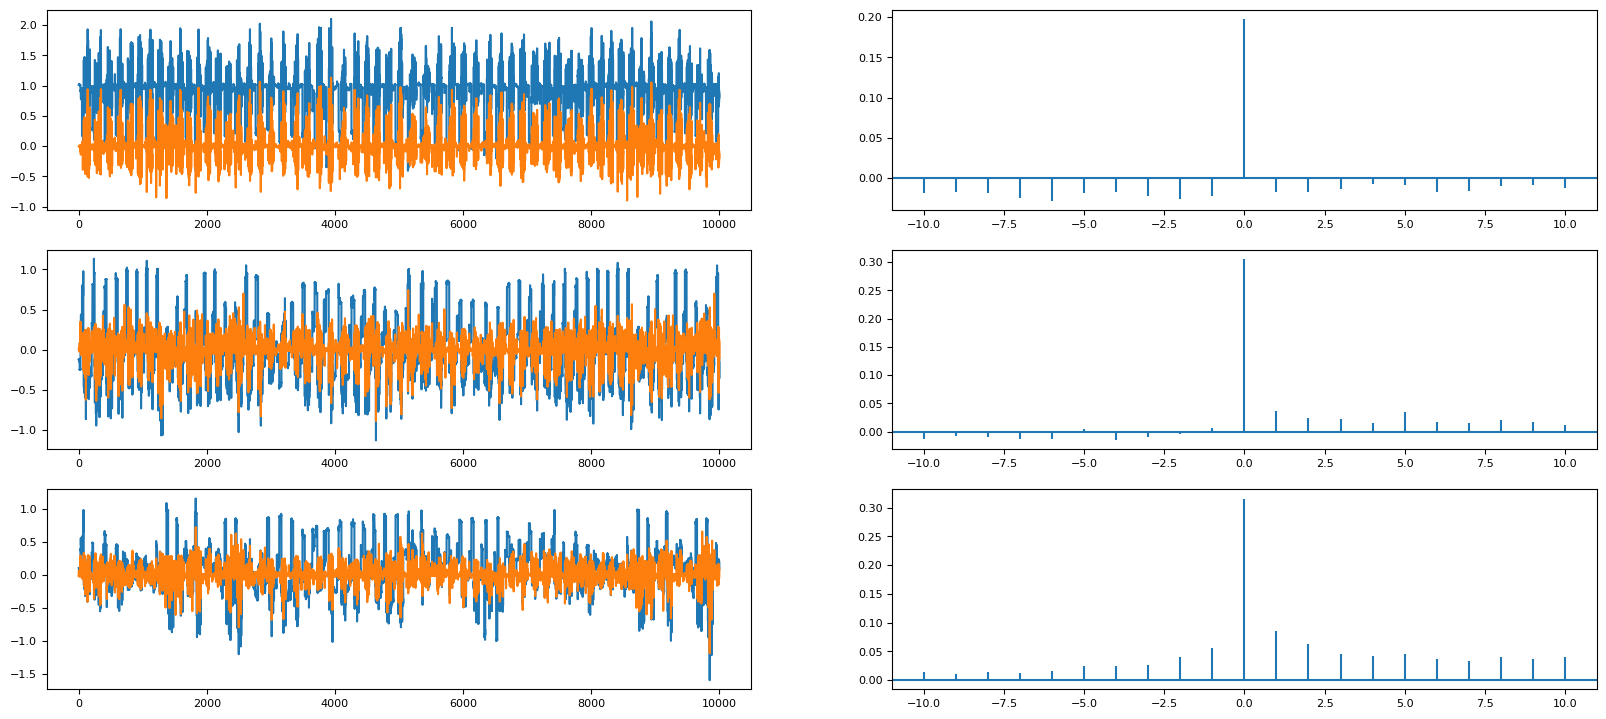

In [7]:
N = 10000

plt.figure(figsize=(20,9), dpi=100)
plt.subplot(3,2,1)
plt.plot(X_train[:N,[0,3]])
plt.subplot(3,2,2)
plt.xcorr(X_train[:N,0], X_train[:N,3])


plt.subplot(3,2,3)
plt.plot(X_train[:N,[1,4]])
plt.subplot(3,2,4)
plt.xcorr(X_train[:N,1], X_train[:N,4])

plt.subplot(3,2,5)
plt.plot(X_train[:N,[2,5]])
plt.subplot(3,2,6)
plt.xcorr(X_train[:N,2], X_train[:N,5])

plt.show()



> Probably, further during optimization we could remove some of them, or merge in some way. But in my experiments I still stay with raw data.

# Model

In [15]:
import torch.nn as nn
import torch.nn.functional as F
import torch as T

In [12]:
def get_model_parametes(model):
    return T.cat([p.view(-1) for p in model.parameters()]).detach().numpy()

def accuracy(a, b):
    return T.sum(a == b) / len(a)


def dsc2dict(dsc):
    return json.loads(json.dumps(dsc.__dict__))

def gen_name(n=6):
    dtime_str = datetime.now().strftime("%Y%d%m_%H%M%S_")
    letters = list('ABCDEFGHIJKLMNOPQRSTUVWXYZ')
    word = ''
    for i in range(n):
        word += letters[np.random.randint(0,len(letters))]
    return dtime_str + word



In my previous experience I have never seriously solved task of multiclass classification, to use such metrics like precision and recall. And I was confused, how to implement them for multiclass task.  
As I understand, they are calculated by the following equations:
$$precision = \frac{\sum_c TP_c}{\sum_c (TP_c + FP_c)}$$
$$recall = \frac{\sum_c TP_c}{\sum_c (TP_c + FN_c)}$$
But in my tests, they returned similar values and I decided not to spend much time for this and tune model first with single $Accuracy$ metric.

In [13]:
# y_pred_oh = F.one_hot(T.argmax(y_pred, 1))

# def precision(y_pred_oh, y):
#     # TP_sum = 0
#     # TPFP_sum = 0
#     out = []
#     for i in range(y.shape[1]):

#         TP_mask = y[:,i] == 1
#         TN_mask = T.logical_not(TP_mask)

#         TP = T.sum(y_pred_oh[:,i][TP_mask])
#         FP = T.sum(y_pred_oh[:,i][TN_mask])

#     #     TP_sum += TP
#     #     TPFP_sum += TP + FP
#         out.append(TP / (TP + FP))

#     # out = TP_sum / TPFP_sum
#     return T.tensor(out)


# def recall(y_pred_oh, y):
#     out = []
#     for i in range(y.shape[1]):

#         TP_mask = y[:,i] == 1

#         TP = T.sum(y_pred_oh[:,i][TP_mask])
#         FN = T.sum(y_pred_oh[:,i][TP_mask] == 0)

#         # TP_sum += TP
#         # TPFN_sum += TP + FN
#         out.append(TP / (TP + FN))

#     # out = TP_sum / TPFN_sum
#     return T.tensor(out)

# print(precision(y_pred_oh, y))
# print(recall(y_pred_oh, y))


## Model

Evolution of my idea was the following:  
1. We need some model with memory
2. First idea was to try some recurrent models
3. But we have multichannel data, and I decided to start from something simple: MLP
4. I slice data with moving window with some memory and got the following data preprocessing $[N_{sample} \times N_{channels}] \rightarrow [N_{sample}  \times Memory\times N_{channels}]]$

In [21]:
class Dataset(T.utils.data.Dataset):
    def __init__(self, X, y, memory):
        self.mem = memory
        self.X = T.tensor(X, dtype=T.float32)
        self.y = T.tensor(y, dtype=T.float32)

    def __len__(self):
        return len(self.y) - self.mem

    def __getitem__(self, ind):
        X = self.X[ind : ind + self.mem, :]
        y = self.y[ind + self.mem, :]
        c = np.argmax(self.y[ind + self.mem, :])
        return X, y, c

dset = Dataset(X_train, y_train, 5)
pprint(dset[0])
pprint(dset[0][0].shape)

(tensor([[ 1.0128e+00, -1.2322e-01,  1.0293e-01,  1.8085e-04,  1.0767e-02,
          5.5561e-02,  3.0191e-02,  6.6014e-02,  2.2859e-02],
        [ 1.0189e+00, -1.2398e-01,  9.7930e-02,  1.0938e-03, -4.6876e-03,
         -2.6860e-02,  1.7111e-02,  6.1228e-03,  1.2268e-02],
        [ 1.0231e+00, -1.2002e-01,  9.1117e-02,  3.5313e-03,  4.4559e-03,
         -5.9146e-03,  2.6189e-02, -2.3834e-04,  2.1589e-03],
        [ 1.0177e+00, -1.3340e-01,  9.5152e-02, -1.7724e-03, -1.0185e-02,
          1.0533e-03, -3.7516e-02, -1.2886e-02, -8.7274e-04],
        [ 1.0200e+00, -1.2873e-01,  8.0841e-02,  8.7477e-05, -3.8569e-03,
         -1.3333e-02, -1.9429e-02, -8.6124e-03, -1.5740e-03]]),
 tensor([0., 0., 0., 0., 1., 0.]),
 tensor(4))
torch.Size([5, 9])


5. For the following experiments I decided to extend dataset with moving averaged version of input data by channels. I could preprocess data for it, but I decided to implement it as model part to make all-in-one solution

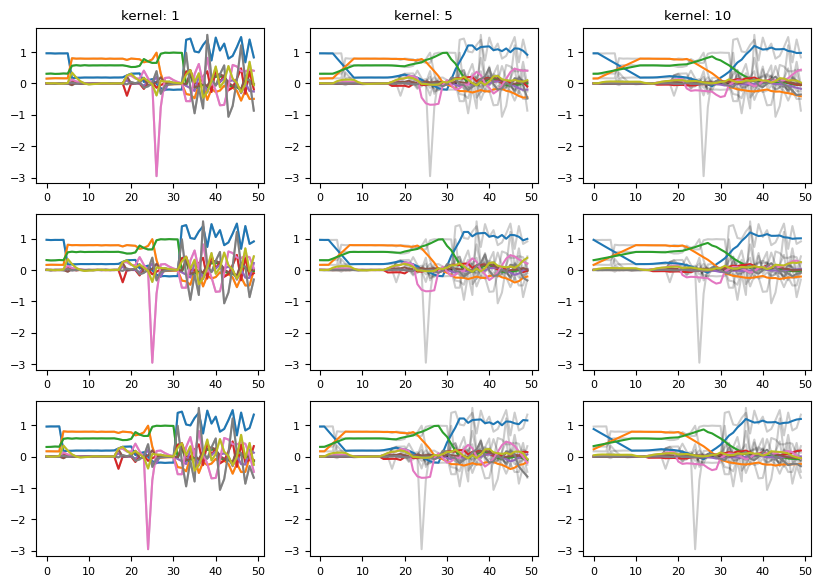

In [22]:
class MovingAverage(nn.Module):
    def __init__(self, kernel=5):
        super().__init__()
        self.conv = nn.Conv1d(1, 1, kernel, 1, padding=int(kernel/2), padding_mode='replicate')
        self.conv.weight.data.fill_(1/kernel)
        self.conv.bias.data.fill_(0)
        for p in self.conv.parameters():
            p.requires_grad = False

    def forward(self, x):
        batchsize, mem, n_ch = x.shape
        y = T.zeros_like(x)
        for i in range(n_ch):
            xi = x[:,:,i:i+1]
            xi = xi.reshape(batchsize,-1,1).permute([0,2,1])
            yi = self.conv(xi).permute([0,2,1])
            y[:,:,i] = T.squeeze(yi[:,:mem,:])
        return y


# --- Test averaging ---

memory = 50
batchsize = 3
train_dset = Dataset(X_train, y_train, memory)
train_load = T.utils.data.DataLoader(train_dset, batchsize)
d = iter(train_load)

clear_output()
[next(d) for _ in range(15)]
X, y, c = next(d)

plt.figure(dpi=100, figsize=(10,7))
kernels = [1,5,10]
for j, k in enumerate(kernels):
    mov_avg = MovingAverage(k)
    X_avg = mov_avg(X)

    T.jit.trace(mov_avg, X_avg)

    for i in range(batchsize):
        plt.subplot(batchsize, len(kernels), j +len(kernels)*i+1)
        plt.plot(X[i].detach(), 'k', alpha=0.2)
        plt.plot(X_avg[i].detach())
        if i == 0:
            plt.title(f'kernel: {k}')

plt.show()

6. So, first attempt was with simple MLP model, which is parametrized by **number of layers** , their **width** and **memory** from outside. Also I added averaging module here

In [23]:
class Model(nn.Module):
    def __init__(self, width=[32, 8], n_ch = 9, memory=10, average_en=False, average_kernel=5):
        super().__init__()
        T.manual_seed(0)
        self.avg_en = average_en
        if self.avg_en:
            self.mov_avg = MovingAverage(average_kernel)
            n_ch *= 2

        self.N = n_ch * memory

        width_ = width.copy()
        width_.insert(0, self.N)
        width_.append(6)

        self.FC = nn.ModuleList()

        for i in range(len(width_)-1):
            self.FC.append(nn.Linear(width_[i], width_[i+1]))

        self.width = width_

    def forward(self, x):
        if self.avg_en:
            x_avg = self.mov_avg(x)
            x = T.cat([x, x_avg], 2)

        batchsize = x.shape[0]
        x = x.reshape(batchsize, 1,-1)
        for i in range(len(self.width)-1):
            x = self.FC[i](x)
            x = F.leaky_relu(x)

        x = F.softmax(x, dim=2).reshape((batchsize, -1))
        return x


memory = 2
batchsize = 4
train_dset = Dataset(X_train, y_train, memory)
train_load = T.utils.data.DataLoader(train_dset, batchsize)
X, y, c = next(iter(train_load))

width = [32,8]
model = Model(width=width, memory=memory, average_en=True)
print(width)
model(X)

[32, 8]


tensor([[0.1794, 0.1570, 0.1568, 0.1570, 0.1570, 0.1928],
        [0.1797, 0.1570, 0.1568, 0.1570, 0.1570, 0.1925],
        [0.1797, 0.1569, 0.1568, 0.1569, 0.1570, 0.1927],
        [0.1797, 0.1569, 0.1568, 0.1570, 0.1570, 0.1926]],
       grad_fn=<ViewBackward>)

7. Later, I also added convolution layers before MLP in the same manner

In [26]:
class ModelConv(nn.Module):
    def __init__(self, width=[32, 8], n_ch = 9, memory=10, out_ch=[3, 3], kernel=[3, 3],
                                                                          average_en=False,
                                                                          average_kernel=5):
        super().__init__()
        T.manual_seed(0)
        self.avg_en = average_en
        if self.avg_en:
            self.mov_avg = MovingAverage(average_kernel)
            n_ch *= 2

        pad = np.sum(np.array(kernel) - 1)
        fc_in = (n_ch-pad) * (memory-pad) * out_ch[-1]

        width_ = width.copy()
        width_.insert(0, fc_in)
        width_.append(6)

        channels = out_ch.copy()
        channels.insert(0, 1)

        # self.pool = nn.MaxPool2d(2, 2)

        self.Conv = nn.ModuleList()
        for i in range(len(channels)-1):
            self.Conv.append(nn.Conv2d(channels[i], channels[i+1], kernel[i]))

        self.FC = nn.ModuleList()
        for i in range(len(width_)-1):
            self.FC.append(nn.Linear(width_[i], width_[i+1]))

        self.width = width_

    def forward(self, x):
        if self.avg_en:
            x_avg = self.mov_avg(x)
            x = T.cat([x, x_avg], 2)

        batchsize, mem, n_ch = x.shape
        x = x.reshape(batchsize, 1, mem, n_ch)

        for i in range(len(self.Conv)):
            x = self.Conv[i](x)
            x = F.leaky_relu(x)
            # x = self.pool(x)

        x = x.reshape(batchsize, 1, -1)
        for i in range(len(self.width)-1):
            x = self.FC[i](x)
            x = F.leaky_relu(x)

        x = F.softmax(x, dim=2).reshape((batchsize, -1))
        return x


memory = 30
batchsize = 4
train_dset = Dataset(X_train, y_train, memory)
train_load = T.utils.data.DataLoader(train_dset, batchsize)
X, y, c = next(iter(train_load))

width = [32,8]
model = ModelConv(width=width, memory=memory, kernel=[3,5], out_ch=[9,3], average_en=True)
print(width)
model(X)

[32, 8]


tensor([[0.1889, 0.1624, 0.1620, 0.1623, 0.1624, 0.1620],
        [0.1889, 0.1624, 0.1620, 0.1623, 0.1624, 0.1620],
        [0.1890, 0.1624, 0.1620, 0.1623, 0.1623, 0.1620],
        [0.1889, 0.1624, 0.1620, 0.1623, 0.1624, 0.1620]],
       grad_fn=<ViewBackward>)

For deeper understanding of model's behaviour, I created such function for visual estimation of algorithm's accuracy.  
Top plot is image from stacked matrices from model's class prediction and target value.  
Bottom plot is corresponding input signals

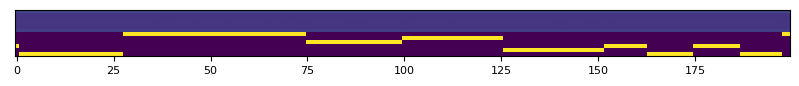

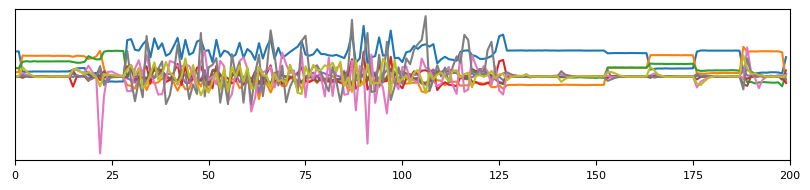

In [95]:
def inspect_model_evaluation(model, X, y, memory, n=200):
    y_pred = model(X)
    y_pred_im = y_pred.detach().numpy().T[:,:n]
    y_im = y[:n].T

    plt.figure(figsize=(10,6), dpi=100)
    plt.imshow(np.vstack([y_pred_im, y_im]))
    plt.yticks([])

    plt.figure(figsize=(10,2), dpi=100)
    plt.plot(X[:,-1,:][:n])
    plt.yticks([])
    plt.xlim([0, n])

    plt.show()

# --------------------------

memory = 50
batchsize = 512
train_dset = Dataset(X_train, y_train, memory)
train_load = T.utils.data.DataLoader(train_dset, batchsize)

X, y, c = next(iter(train_load))
model = ModelConv(memory=memory)

inspect_model_evaluation(model, X, y, memory, 200)

Example on already trained model:

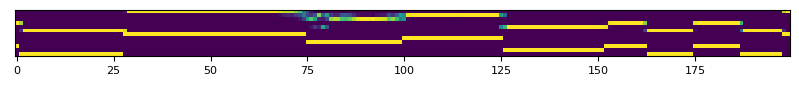

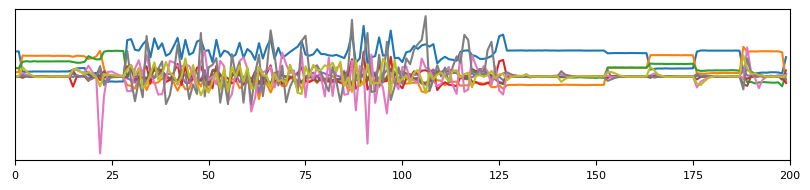

In [97]:
model = T.jit.load('data/run_20211911_125018_OXPCGW_model.pth')
inspect_model_evaluation(model, X, y, 200)

In `run_train` function was implemented train and test loops, saving checkpoint and model data, and plottig current metrics and estimations

In [59]:
def run_train(dsc, train_load, test_load):
    if dsc.model == 'mlp':
        model = Model(width=dsc.width,
                      memory=dsc.memory,
                      average_en=dsc.avg_en,
                      average_kernel=dsc.avg_kernel)

    elif dsc.model == 'conv':
        model = ModelConv(width=dsc.width,
                          memory=dsc.memory,
                          kernel=dsc.kernel,
                          out_ch=dsc.out_ch,
                          average_en=dsc.avg_en,
                          average_kernel=dsc.avg_kernel)
    else:
        raise 'Invalid model'

    optimizer = T.optim.Adam(model.parameters(), lr=dsc.lr)
    criterion = nn.BCELoss()
    scheduler = T.optim.lr_scheduler.StepLR(optimizer=optimizer, gamma=dsc.lr_gamma, step_size=1)

    loss_arr = []
    acc_train_sum_arr = []
    acc_test_sum_arr = []
    acc_train_ep_arr = []
    acc_test_ep_arr = []

    recall_arr = []
    for ep in range(dsc.n_epoch):
        print(f'------------ Epoch {ep+1} ------------')

        acc_train_arr = []
        acc_test_arr = []

        model.train()
        for X, y, c in tqdm(train_load):
            n_class = y.shape[1]
            y_pred = model(X)

            loss = criterion(y_pred, y)
            c_pred = T.argmax(y_pred, 1)
            c_pred_oh = F.one_hot(c_pred, n_class)

            loss_i = loss.detach().numpy()
            acc_i = accuracy(c_pred, c)

            loss_arr.append(loss_i)
            acc_train_arr.append(acc_i)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            ### DEBUG EARLY STOP
            # if (len(loss_arr)+1) % 20 == 0:
            #     break

        print(f'Accuracy train: {np.mean(acc_train_arr)}')

        model.eval()
        for X, y, c in tqdm(test_load):
            y_pred = model(X)
            c_pred = T.argmax(y_pred, 1)

            acc_i = accuracy(c_pred, c)
            acc_test_arr.append(acc_i)

            ### DEBUG EARLY STOP
            # if (len(acc_test_arr)+1) % 5 == 0:
            #     break

        scheduler.step()

        print(f'Accuracy test: {np.mean(acc_test_arr)}')
        # print(f'Accuracy train/test: {acc_train_arr[-1]} / {acc_test_arr[-1]}')

        acc_train_sum_arr.extend(acc_train_arr)
        acc_test_sum_arr.extend(acc_test_arr)

        acc_train_ep_arr.append(np.mean(acc_train_arr))
        acc_test_ep_arr.append(np.mean(acc_test_arr))

        plt.figure(figsize=(20,5))
        plt.subplot(1,3,1)
        plt.plot(np.array(loss_arr), '.', alpha=0.3)
        plt.grid(True)

        plt.subplot(1,3,2)
        plt.plot(acc_train_ep_arr)
        plt.plot(acc_test_ep_arr)
        plt.grid(True)

        plt.subplot(1,3,3)
        plt.plot(acc_train_sum_arr, '.')
        plt.plot(acc_test_sum_arr, '.')
        plt.grid(True)

        plt.savefig('convergence.png')
        plt.show()

        inspect_model_evaluation(model, X, y, dsc.memory, 200)

        dscDict = dsc2dict(dsc)
        dscDict['acc_train_ep_arr'] = acc_train_ep_arr
        dscDict['acc_test_ep_arr'] = acc_test_ep_arr
        dscDict['acc_train'] = acc_train_ep_arr[-1]
        dscDict['acc_test'] = acc_test_ep_arr[-1]

        summary = pd.DataFrame([])
        s = pd.Series(dscDict)
        summary = summary.append(s, ignore_index=True)

        summary['name'] = dsc.name
        checkpoint = dict()
        # checkpoint['dsc'] = dsc
        # checkpoint['model'] =
        checkpoint['summary'] = summary
        checkpoint['inut_shape'] = X.shape

        model_trace = T.jit.trace(model, X)

        T.save(checkpoint, f"data/{dsc.name}.pth")
        T.jit.save(model_trace, f"data/{dsc.name}_model.pth")

    return summary, model

# ----------------------------------------------------------------------


This is core cell of my work. From this I launched search of algorithm parameters and tuned model.

In [ ]:

try:
    summary_df = pd.read_json('summary.json')
except:
    summary_df = pd.DataFrame([])

class DSC:
    pass

dsc = DSC()
dsc.width = [32, 16]
dsc.lr = 0.0003
dsc.memory = 3
dsc.batch_train = 1024
dsc.batch_test = 4096
dsc.n_epoch = 3
dsc.lr_gamma = 0.8
dsc.kernel = [3]
dsc.out_ch = [3]
dsc.model = 'mlp' # ['mlp', 'conv']
dsc.avg_en = True
dsc.avg_kernel = 5


for model in ['conv']:
    for lr_gamma in [0.8]:
        for mem in [50]:
            for batchsize in [512]:
                for lr in [0.001]:
                    for width in [[48,16], [64, 16]]:
                        for kernel in [[3,3]]:
                            for out_ch in [[9, 9]]:
                                for avg_en in [True, False]:
                                    for avg_kernel in [5,10,20]:

                                        if len(summary_df) > 0:
                                            summary_df['width_str'] = summary_df.width.apply(str)
                                            summary_df['kernel_str'] = summary_df.kernel.apply(str)
                                            summary_df['out_ch_str'] = summary_df.out_ch.apply(str)

                                            query_str = f'memory == {mem} and \
                                                        batch_train == {batchsize} and \
                                                        lr == {lr} and \
                                                        lr_gamma == {lr_gamma} and \
                                                        n_epoch == {dsc.n_epoch} and \
                                                        kernel_str == {str(kernel)} and \
                                                        out_ch_str == {str(out_ch)} and \
                                                        model == "{dsc.model}" and \
                                                        avg_en == "{dsc.avg_en}" and \
                                                        avg_kernel == "{dsc.avg_kernel}" and \
                                                        width_str == "{str(width)}"'

                                            eperiment_is_present = len(summary_df.query(query_str)) > 0
                                        else:
                                            eperiment_is_present = False


                                        if eperiment_is_present:
                                            print('configuration is present:')
                                            print(dsc.__dict__)
                                        else:
                                            clear_output()

                                            expname = 'run_' + gen_name()
                                            print(expname)

                                            dsc.memory = mem
                                            dsc.batch_train = batchsize
                                            dsc.width = width
                                            dsc.lr = lr
                                            dsc.lr_gamma = lr_gamma
                                            dsc.kernel = kernel
                                            dsc.out_ch = out_ch
                                            dsc.name = expname
                                            dsc.avg_kernel = avg_kernel
                                            dsc.avg_en = avg_en
                                            dsc.model = model
                                            pprint(dsc.__dict__)

                                            train_dset = Dataset(X_train, y_train, dsc.memory)
                                            test_dset = Dataset(X_test, y_test, dsc.memory)

                                            train_load = T.utils.data.DataLoader(train_dset, dsc.batch_train)
                                            test_load = T.utils.data.DataLoader(test_dset, dsc.batch_test)


                                            summary_i, model = run_train(dsc, train_load, test_load)

                                            summary_df = summary_df.append(summary_i, ignore_index=True)

                                            summary_df.to_json('summary.json')


                                        # summary_df.to_json('summary.json')


summary_df


# Experiments analyzing

While in one kernel were trained models, in another I estimated experimant progress by analyzing runs data, which was saved as `pd.DatafFrame`.  
Here I merged this notebooks

In [28]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import dsplot as dp
import collections

%matplotlib inline

Some support functions

In [29]:
def num2str(x, prec=4):
    if isinstance(x, str):
        s = x
    else:
        if isinstance(x, collections.abc.Iterable):
            s = str(s)
        else:
            if not (x is None or str(x) == 'nan'):
                if x % 1:
                    s = str(round(x, prec))
                else:
                    s = str(int(x))
            else:
                s = 'None'
    return s

def extract_legend(df, cols=[]):
    if not cols:
        cols = df.columns

    leg_list = []
    for i in range(df.shape[0]):
        legend_val = df.iloc[i][cols]
        legend_val = [num2str(v,3) for v in legend_val]
        legend = ', '.join(legend_val)
        leg_list.append(legend)

    return leg_list, cols


## 1. MLP

### First train probing. Preestimate memory and batchsize

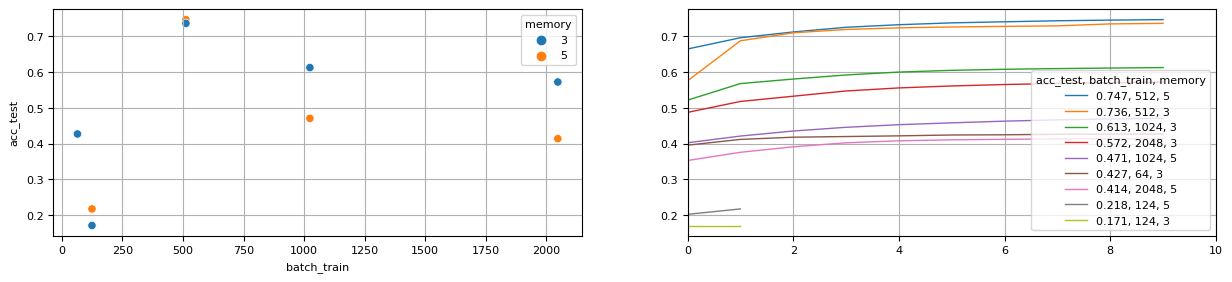

In [41]:
df = pd.read_json('summary_1.json')
df['width_str'] = df.width.apply(str)
df = df.sort_values(by='acc_test', ascending=False)

plt.figure(figsize=(15,3), dpi=100)

plt.subplot(1,2,1)
sns.scatterplot(data=df, x='batch_train', y='acc_test', hue='memory', palette='tab10')
plt.grid(True)

legend, cols = extract_legend(df, ['acc_test', 'batch_train', 'memory'])
color_map = None

plt.subplot(1,2,2)
dp.plot(df.acc_test_ep_arr, legend=legend, group_map=color_map, show=False, new=False)
plt.legend(title=', '.join(cols))
plt.show()

### Estimate optimal learning rate

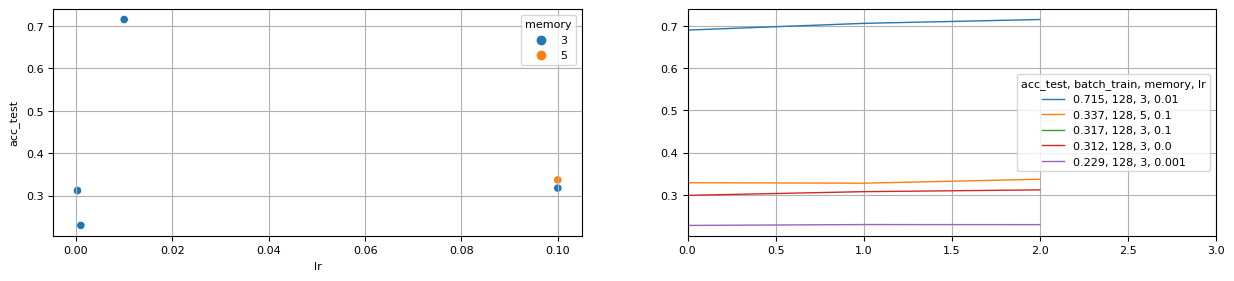

In [45]:
df = pd.read_json('summary_lr.json')
df['width_str'] = df.width.apply(str)
df = df.sort_values(by='acc_test', ascending=False)

plt.figure(figsize=(15,3), dpi=100)

plt.subplot(1,2,1)
sns.scatterplot(data=df, x='lr', y='acc_test', hue='memory', palette='tab10')
plt.grid(True)

legend, cols = extract_legend(df, ['acc_test', 'batch_train', 'memory', 'lr'])
color_map = None

plt.subplot(1,2,2)
dp.plot(df.acc_test_ep_arr, legend=legend, group_map=color_map, show=False, new=False)
plt.legend(title=', '.join(cols))
plt.show()

### Tune model width and batchsize

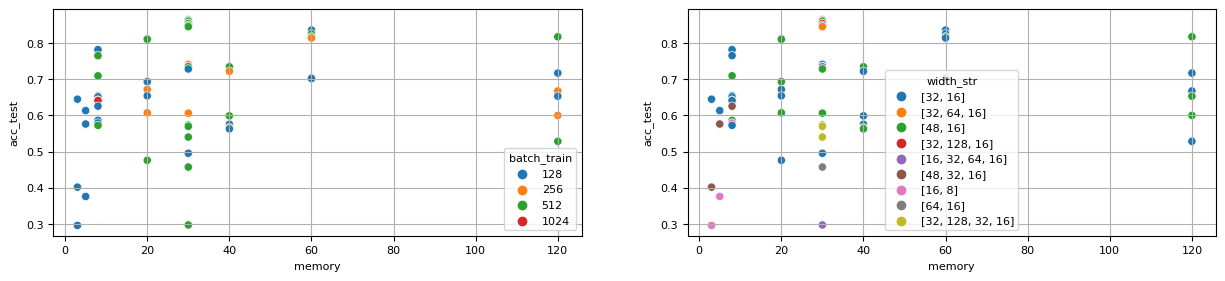

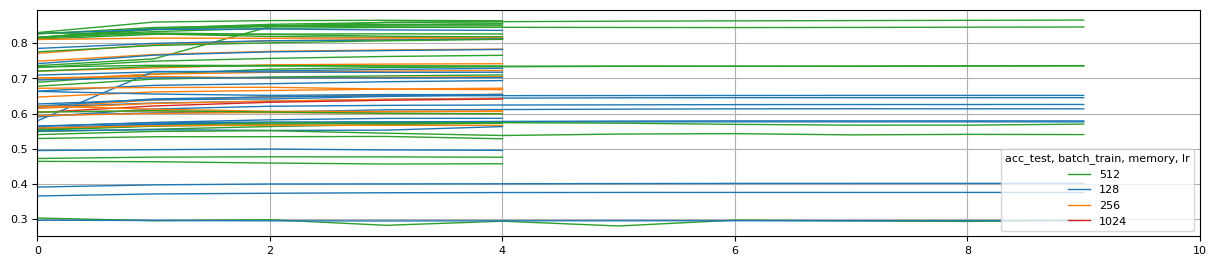

In [55]:
df = pd.read_json('summary_mlp.json')
df['width_str'] = df.width.apply(str)
df = df.sort_values(by='acc_test', ascending=False)


plt.figure(figsize=(15,3), dpi=100)
plt.subplot(1,2,1)
sns.scatterplot(data=df, x='memory', y='acc_test', hue='batch_train', palette='tab10')
plt.grid(True)
plt.subplot(1,2,2)
sns.scatterplot(data=df, x='memory', y='acc_test', hue='width_str', palette='tab10')
plt.grid(True)

legend, cols = extract_legend(df, ['acc_test', 'batch_train', 'memory', 'lr'])
color_map = df.batch_train

plt.figure(figsize=(15,3), dpi=100)
dp.plot(df.acc_test_ep_arr, legend=legend, group_map=color_map, show=False, new=False, lw_scale=False)
plt.legend(title=', '.join(cols))
plt.show()

In [66]:
df.iloc[:5][['acc_test', 'acc_train', 'width', 'batch_train', 'memory', 'lr']]

acc_test  acc_train          width  batch_train  memory     lr
61  0.865760   0.938613       [32, 16]          512      30  0.001
51  0.863678   0.945579   [32, 64, 16]          512      30  0.001
43  0.861266   0.934563       [48, 16]          512      30  0.001
54  0.855187   0.933754   [32, 64, 16]          512      30  0.001
52  0.854925   0.942984  [32, 128, 16]          512      30  0.001

Next iteration was adding convolution layers

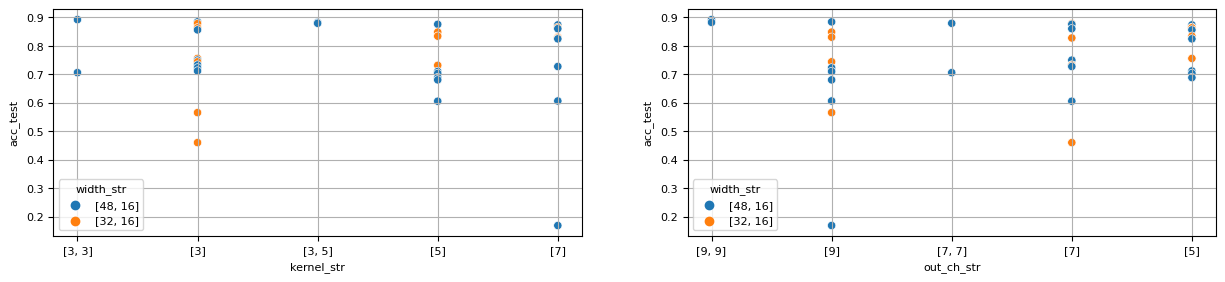

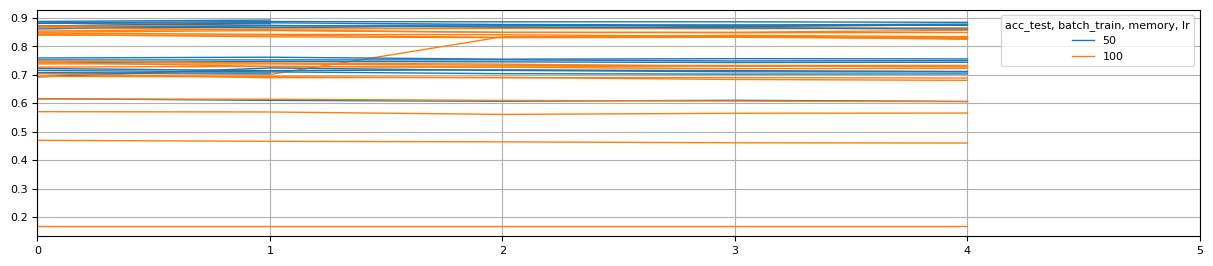

In [72]:
df = pd.read_json('summary_conv2.json')
df['width_str'] = df.width.apply(str)
df['kernel_str'] = df.kernel.apply(str)
df['out_ch_str'] = df.out_ch.apply(str)
df = df.sort_values(by='acc_test', ascending=False)


plt.figure(figsize=(15,3), dpi=100)
plt.subplot(1,2,1)
sns.scatterplot(data=df, x='kernel_str', y='acc_test', hue='width_str', palette='tab10')
plt.grid(True)
plt.subplot(1,2,2)
sns.scatterplot(data=df, x='out_ch_str', y='acc_test', hue='width_str', palette='tab10')
plt.grid(True)

legend, cols = extract_legend(df, ['acc_test', 'batch_train', 'memory', 'lr'])
color_map = df.memory

plt.figure(figsize=(15,3), dpi=100)
dp.plot(df.acc_test_ep_arr, legend=legend, group_map=color_map, show=False, new=False, lw_scale=False)
plt.legend(title=', '.join(cols))
plt.show()

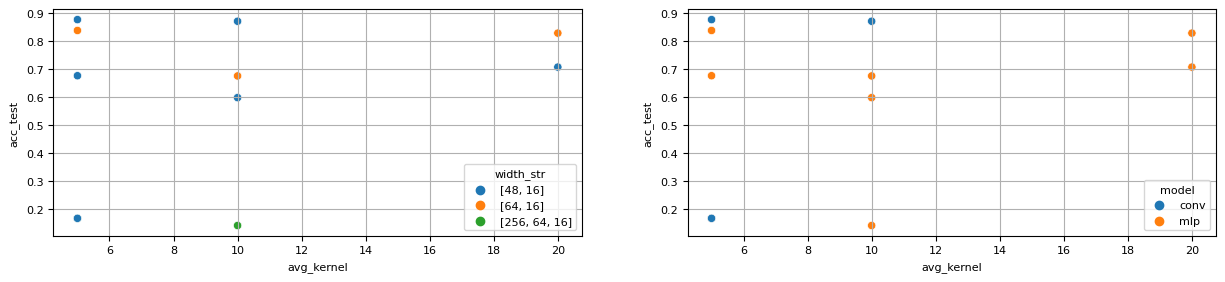

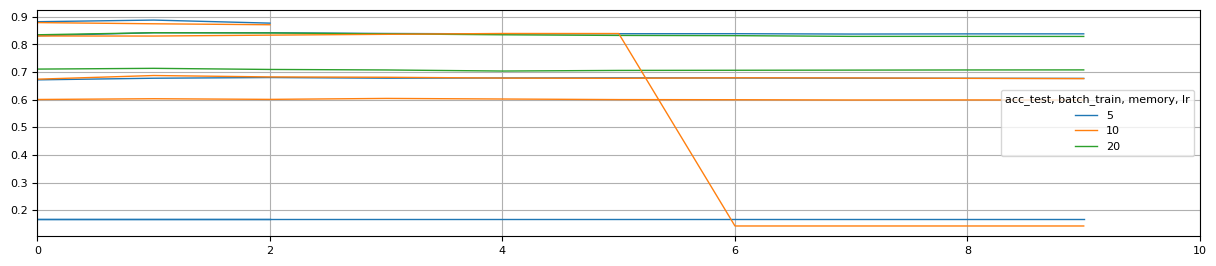

In [91]:
df = pd.read_json('summary.json')
df['width_str'] = df.width.apply(str)
df['kernel_str'] = df.kernel.apply(str)
df['out_ch_str'] = df.out_ch.apply(str)
df = df.sort_values(by='acc_test', ascending=False)


plt.figure(figsize=(15,3), dpi=100)
plt.subplot(1,2,1)
sns.scatterplot(data=df, x='avg_kernel', y='acc_test', hue='width_str', palette='tab10')
plt.grid(True)
plt.subplot(1,2,2)
sns.scatterplot(data=df, x='avg_kernel', y='acc_test', hue='model', palette='tab10')
plt.grid(True)

legend, cols = extract_legend(df, ['acc_test', 'batch_train', 'memory', 'lr'])
color_map = df.avg_kernel

plt.figure(figsize=(15,3), dpi=100)
dp.plot(df.acc_test_ep_arr, legend=legend, group_map=color_map, show=False, new=False, lw_scale=False)
plt.legend(title=', '.join(cols))
plt.show()

In [92]:
df.iloc[:5][['acc_test', 'acc_train', 'width', 'batch_train', 'memory', 'lr', 'avg_kernel', 'model', 'name']]

acc_test  acc_train     width  batch_train  memory     lr  avg_kernel  \
9   0.876881   0.970790  [48, 16]          512      50  0.001           5   
10  0.871044   0.970407  [48, 16]          512      50  0.001          10   
3   0.838144   0.981062  [64, 16]          512      50  0.001           5   
5   0.828735   0.979024  [64, 16]          512      50  0.001          20   
2   0.707660   0.801025  [48, 16]          512      50  0.001          20   

   model                        name  
9   conv  run_20211911_125018_OXPCGW  
10  conv  run_20211911_134517_CPPGEL  
3    mlp  run_20211911_082456_LSWPKI  
5    mlp  run_20211911_092205_WGFENB  
2    mlp  run_20211911_075544_TZIFXD

In [84]:
final_model = T.jit.load('data/run_20211911_125018_OXPCGW_model.pth')
final_model

RecursiveScriptModule(
  original_name=ModelConv
  (mov_avg): RecursiveScriptModule(
    original_name=MovingAverage
    (conv): RecursiveScriptModule(original_name=Conv1d)
  )
  (Conv): RecursiveScriptModule(
    original_name=ModuleList
    (0): RecursiveScriptModule(original_name=Conv2d)
    (1): RecursiveScriptModule(original_name=Conv2d)
  )
  (FC): RecursiveScriptModule(
    original_name=ModuleList
    (0): RecursiveScriptModule(original_name=Linear)
    (1): RecursiveScriptModule(original_name=Linear)
    (2): RecursiveScriptModule(original_name=Linear)
  )
)

In [93]:
T.load('data/run_20211911_125018_OXPCGW.pth')['summary']

acc_test                   acc_test_ep_arr  acc_train  \
0  0.876881  [0.8820676, 0.8879645, 0.876881]    0.97079   

                   acc_train_ep_arr  avg_en  avg_kernel  batch_test  \
0  [0.8797641, 0.956481, 0.9707896]     1.0         5.0      4096.0   

   batch_train  kernel     lr  lr_gamma  memory model  n_epoch  \
0        512.0  [3, 3]  0.001       0.8    50.0  conv      3.0   

                         name  out_ch     width  
0  run_20211911_125018_OXPCGW  [9, 9]  [48, 16]

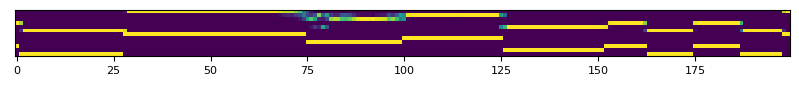

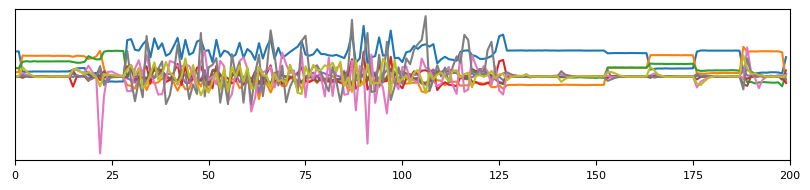

In [98]:
final_model = T.jit.load('data/run_20211911_125018_OXPCGW_model.pth')
inspect_model_evaluation(final_model, X, y, 200)